In [64]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split


import numpy as np
from PIL import Image

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


%matplotlib inline

In [65]:
# The downloading process may take a few minutes. 
vgg_model = models.vgg16(pretrained=True)# return the vgg-16 model pretrained on ImageNet dataset.

In [66]:
# Define preprocessing function of the input images
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(4096), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [67]:
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them

dir_path = "Data/" 
dataset = preprocess_image(dir_path)
dataset

Dataset ImageFolder
    Number of datapoints: 84916
    Root location: Data/
    StandardTransform
Transform: Compose(
               Resize(size=4096, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [68]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [64916, 20000])

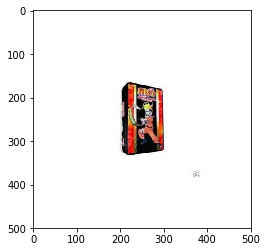

In [69]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

In [70]:
dataset.imgs[index][0]

'Data/image_train/image_1000095647_product_148177050.jpg'

In [71]:
vgg_model.eval()
output = vgg_model(dataset[index][0].view(1, 3, 224, 224))

values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy())
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [387 335 653]
Raw class scores: [7.237319  6.5728335 6.219266 ]


In [72]:
# Freeze model weights
for param in vgg_model.parameters():
    param.requires_grad = False

In [79]:
import torch.nn as nn
# Add on classifier
vgg_model.classifier[6] = nn.Sequential(
                      nn.Linear(10, 4096), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 27),                   
                      nn.LogSoftmax(dim=1))

In [80]:
vgg_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=10, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=27, bias=True)
    (4): LogSoftmax()
  )
)

In [81]:
from torch import optim
# Loss and optimizer
criteration = nn.NLLLoss()
optimizer = optim.Adam(vgg_model.parameters())

In [82]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [83]:
num_epochs = 25
batch_size = 10

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1

In [84]:
from datetime import datetime
tic = datetime.now()
train_error = train(num_epochs, batch_size, criterion, optimizer, vgg_model, train_set)
tac = datetime.now()

RuntimeError: size mismatch, m1: [10 x 4096], m2: [10 x 4096] at /Users/distiller/project/conda/conda-bld/pytorch_1579022061893/work/aten/src/TH/generic/THTensorMath.cpp:136